In [1]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.utils.plotting import plot_trajectories, plot_height, plot_crash_site, slice_by_time
import numpy as np
from deorbit.observer import Observer


This notebook exists to show an example of the EKF module being used in the 2D space. The simulator has been initialised using the RK4 numerical integrator, the fastest atmospheric method and some noise. 

In [2]:
save_path = "eg/EKF_example_noise_2s/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


The observer has been initialised using 10 equally spaced radars and a checking interval of 2 minutes.

In [3]:
obs = Observer(number_of_radars=10)

sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)

The process noise, error covariance and measurement matrix are all defined as a singular matrix, whereas the measurement noise matrix is defined for for each measurement from the observation module.
The _ekf.run()__ returns the estiamted trajectory, its uncertainities and the corresponding time array for the states.

In [4]:
# Define process and measurement noise covariance matrices
Q = np.diag([0.1, 0.1, 0.01, 0.01])#process noise
P = np.eye(4) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly)
H = np.eye(4)

dt = sim_config.simulation_method_kwargs.time_step

ekf = EKF()

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

100%|██████████| 69/69 [00:03<00:00, 18.43it/s]


We can then plot the whole trajectory, including the estimated trajectories.

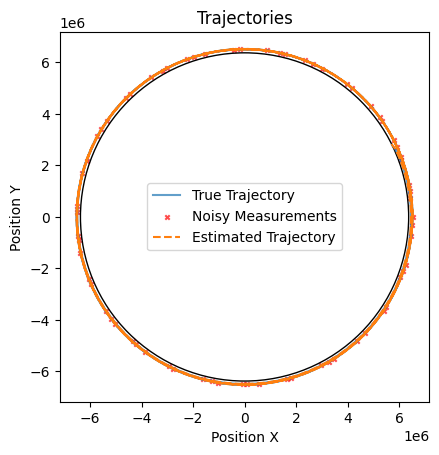

In [5]:
true_traj = sim_data.state_array()[:, :2]

plot_trajectories(true_traj, observations=observation_states, estimated_traj=estimated_traj)

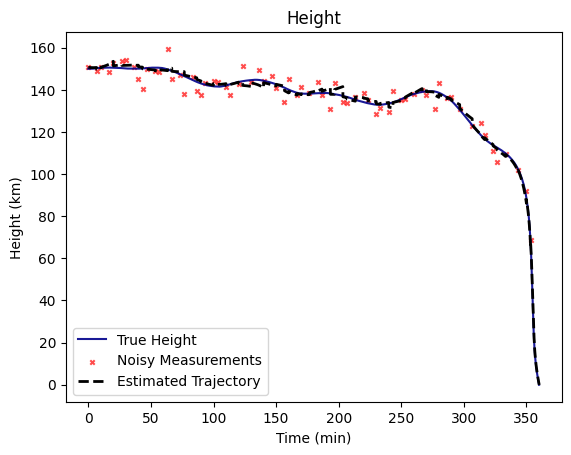

In [6]:
plot_height(true_traj, observations=observation_states, estimated_traj=estimated_traj, observation_times=observation_times, estimated_times=estimated_times, times=sim_times)

Can plot slices of the trajectory and the crash site

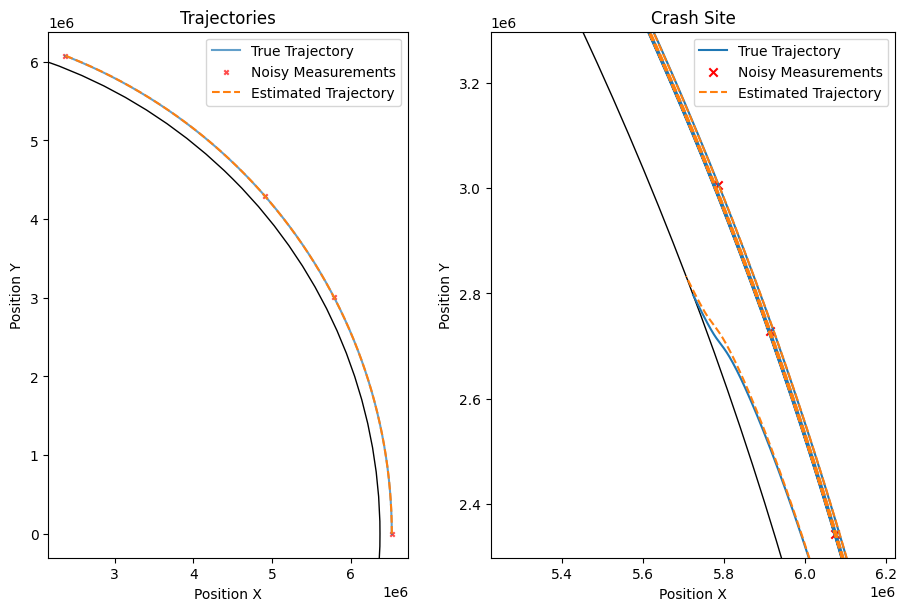

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 6))

plot_duration = 1000

start_time = observation_times[0]
end_time = start_time + plot_duration

true_traj_sliced, _ = slice_by_time(true_traj, sim_times, start_time, end_time)
observation_states_sliced, _ = slice_by_time(observation_states, observation_times, start_time, end_time)
estimated_traj_sliced, _ = slice_by_time(estimated_traj, estimated_times, start_time, end_time)

plot_trajectories(true_traj_sliced, observations=observation_states_sliced, estimated_traj=estimated_traj_sliced, ax=ax1, show=False, tight=True)

plot_crash_site(true_traj, estimated_traj, observation_states, ax=ax2, show=False)

fig.set_constrained_layout(True)
plt.show()

[1.06067571e+03 1.06073798e+03 1.06092763e+03 ... 2.88961907e+42
 8.76027081e+42 2.67155323e+43]


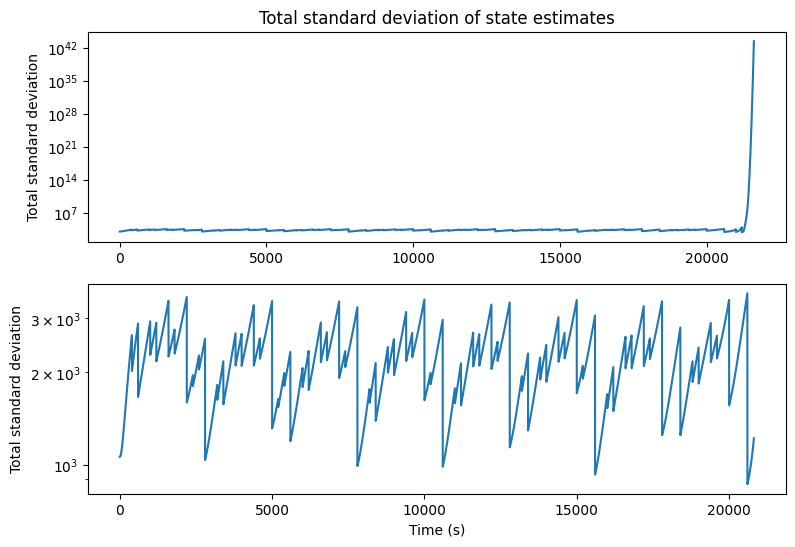

In [14]:
total_std = np.sqrt(np.trace(uncertainties, axis1=1, axis2=2))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 6))
ax1.semilogy(estimated_times, total_std)
ax2.semilogy(estimated_times[:-400], total_std[:-400])
ax1.set_title("Total standard deviation of state estimates")
ax2.set_xlabel("Time (s)")
ax1.set_ylabel("Total standard deviation")
ax2.set_ylabel("Total standard deviation")
plt.show()